# Structural Alignment and Evolutionary Analysis of Fusexin Proteins

Welcome! In this notebook, you will explore the structure and evolution of fusexin proteins using hands-on bioinformatics tools and methods. The protein structures are provided in the `example_fusexins` directory and are based on [this Nature Communications article](https://www.nature.com/articles/s41467-022-31564-1).

## Objectives
- **Visualize protein structures:** Explore and inspect fusexin protein 3D structures.
- **Structural alignment:** Apply multiple methods to align and compare protein structures.
- **Sequence analysis:** Perform sequence alignments and build phylogenetic trees.
- **Advanced analysis:** Use the foldtree method for deeper structural insights.

## Workflow Overview
1. Visualize fusexin protein structures
2. Align and compare structures
3. Perform sequence alignment and phylogenetic analysis
4. Apply foldtree for advanced structural analysis

---

Let's get started!

In [105]:
cd projects/Structural_evo_tutorial/Structural_evo_tutorial/

[Errno 2] No such file or directory: 'projects/Structural_evo_tutorial/Structural_evo_tutorial/'
/home/dmoi/projects/Structural_evo_tutorial/Structural_evo_tutorial


In [106]:
#let's load the dataset

import glob
fusexins = glob.glob( './fsx1/*.pdb')
print( len(fusexins), 'fusexins found')
print( fusexins[0:5] , '...' )

18 fusexins found
['./fsx1/WP_049937247_Hnatans.pdb', './fsx1/5mf1_C_reinhardtii.pdb', './fsx1/1OAN_Dengue.pdb', './fsx1/7P4L_metageno_halo.pdb', './fsx1/WP_058826362_Haloferax.pdb'] ...


### Structural Organization of Class II Fusion Proteins

Class II fusion proteins / fusexins are typically organized into three distinct domains:

- **Domain I:** This central domain is β-rich and stabilized by multiple disulfide bonds. It forms the core scaffold of the protein and often contains the hydrophobic "fusion loop" at its tip. The fusion loop is critical for initiating membrane fusion, as it inserts into the target membrane to promote the merging of lipid bilayers.

- **Domain II:** Like Domain I, Domain II is also β-rich and stabilized by disulfide bonds. It is usually elongated and forms an extended structure that helps position the fusion loop for membrane engagement.

- **Domain III:** This domain adopts a classic immunoglobulin (Ig)-like fold. It is more globular and is thought to contribute to the structural stability and proper folding of the fusion protein.

The spatial arrangement of these domains allows the fusion loop in Domain I to be optimally positioned for membrane insertion, while Domains II and III provide structural support and flexibility necessary for the large conformational changes that drive membrane fusion.

In [107]:
import py3Dmol
#let's visualize the first one with py3Dmol and use domain specific colors

def visualize_structure_with_coloring(pdb_path, color_ranges, chain_id='A', alpha=0.7):
	"""
	Visualize a protein structure with colored ribbon and opaque grey surface using py3Dmol.

	Args:
		pdb_path (str): Path to the PDB file.
		color_ranges (list of tuples): List of (start_res, end_res, color) for coloring.
		chain_id (str): Chain ID to visualize (default: 'A').
		alpha (float): Opacity for the surface (0.0 to 1.0).
	"""
	with open(pdb_path) as f:
		pdb_data = f.read()

	view = py3Dmol.view(width=600, height=400)
	view.addModel(pdb_data, 'pdb')
	# Add opaque grey surface
	view.addSurface(py3Dmol.VDW, {'opacity': alpha, 'color': 'grey', 'sele': {'chain': chain_id}})
	# Add colored cartoon for specified ranges
	for start, end, color in color_ranges:
		selection = {'chain': chain_id, 'resi': list(range(start, end + 1))}
		view.addCartoon({'sele': selection, 'color': color})
	# Show the rest of the chain in light grey
	view.addCartoon({'sele': {'chain': chain_id}, 'color': 'lightgrey'})
	view.zoomTo({'chain': chain_id})
	return view



In [108]:
import py3Dmol

def visualize_structure_with_coloring(pdb_path, color_ranges, chain_id='A', alpha=0.7):
	"""
	Visualize a protein structure with colored ribbon and opaque grey surface using py3Dmol.

	Args:
		pdb_path (str): Path to the PDB file.
		color_ranges (list of tuples): List of (start_res, end_res, color) for coloring.
		chain_id (str): Chain ID to visualize (default: 'A').
		alpha (float): Opacity for the surface (0.0 to 1.0).
	"""
	with open(pdb_path) as f:
		pdb_data = f.read()

	view = py3Dmol.view(width=600, height=400)
	view.addModel(pdb_data, 'pdb')
	# Add opaque grey surface
	view.addSurface(py3Dmol.VDW, {'opacity': alpha, 'color': 'grey', 'sele': {'chain': chain_id}})
	# Add colored cartoon for specified ranges
	for start, end, color in color_ranges:
		selection = {'chain': chain_id, 'resi': list(range(start, end + 1))}
		view.addCartoon({'sele': selection, 'color': color})
	# Show the rest of the chain in light grey
	view.addCartoon({'sele': {'chain': chain_id}, 'color': 'lightgrey'})
	view.zoomTo({'chain': chain_id})
	return view

In [109]:
from Bio.PDB import Superimposer, PDBParser
from Bio.PDB import PDBIO
import tempfile
import py3Dmol

def rigid_body_align(structure_path1, structure_path2, chain_id1='A', chain_id2='A'):
	"""
	Align two protein structures using rigid body superposition.

	Returns:
		rmsd (float): Root mean square deviation after alignment.
		super_imposer (Superimposer): Biopython Superimposer object.
		structure1, structure2: Biopython Structure objects (structure2 is superposed).
		view (py3Dmol.view): py3Dmol view showing the superposed structures.
	"""
	parser = PDBParser(QUIET=True)
	structure1 = parser.get_structure('struct1', structure_path1)
	structure2 = parser.get_structure('struct2', structure_path2)

	atoms1 = [atom for atom in structure1[0].get_atoms() if atom.get_id() == 'CA']
	atoms2 = [atom for atom in structure2[0].get_atoms() if atom.get_id() == 'CA']

	min_len = min(len(atoms1), len(atoms2))
	atoms1 = atoms1[:min_len]
	atoms2 = atoms2[:min_len]

	sup = Superimposer()
	sup.set_atoms(atoms1, atoms2)
	sup.apply(structure2.get_atoms())

	# Save structures to temp files for visualization
	io = PDBIO()
	# structure1
	tmp1 = tempfile.NamedTemporaryFile(delete=False, suffix='.pdb')
	io.set_structure(structure1)
	io.save(tmp1.name)
	# structure2 (already superposed)
	tmp2 = tempfile.NamedTemporaryFile(delete=False, suffix='.pdb')
	io.set_structure(structure2)
	io.save(tmp2.name)

	# Visualize with py3Dmol
	with open(tmp1.name) as f1, open(tmp2.name) as f2:
		pdb1 = f1.read()
		pdb2 = f2.read()
	view = py3Dmol.view(width=600, height=400)
	view.addModel(pdb1, 'pdb')
	view.setStyle({'model': 0}, {'cartoon': {'color': 'spectrum'}})
	view.addModel(pdb2, 'pdb')
	view.setStyle({'model': 1}, {'cartoon': {'color': 'magenta'}})
	view.zoomTo()
	return sup.rms, sup, structure1, structure2, view


In [110]:
#let's try some structure pairs
import itertools
import random
combos = [ ( i, j ) for i, j in itertools.combinations(range(len(fusexins)), 2) ]
sample = random.sample(combos, 5)
for i, j in sample:
	print( i, j, fusexins[i], fusexins[j] )
	rms, sup, structure1, structure2, view = rigid_body_align(fusexins[i], fusexins[j])
	view.show()
	print( 'RMSD:', rms)
# The above code will align the first two structures in the list and print the RMSD.
# lets also save the aligned structures
sup.apply(structure2.get_atoms())
# Save the aligned structure


12 14 ./fsx1/5OW3_A_thaliana.pdb ./fsx1/1SVB_Tick_encephalitis.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

RMSD: 31.978460151905963
2 5 ./fsx1/1OAN_Dengue.pdb ./fsx1/WP_007110832_Naltunense.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

RMSD: 36.476058662405805
5 16 ./fsx1/WP_007110832_Naltunense.pdb ./fsx1/2ALA_semliki_forest.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

RMSD: 37.12725241248596
13 14 ./fsx1/6EGU_Rift_valley_fever_virus.pdb ./fsx1/1SVB_Tick_encephalitis.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

RMSD: 28.040009037155542
5 11 ./fsx1/WP_007110832_Naltunense.pdb ./fsx1/1RER_Semliki_Forest_virus.pdb


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

RMSD: 36.129929523475674


## Structural Homology Despite Conformational Diversity

The structural alignments above demonstrate that these fusexin proteins are homologous, sharing a common evolutionary origin. However, their overall conformations can differ significantly. In some cases, large domain movements or flexible regions may cause parts of the structures to be misaligned, resulting in higher RMSD values even when the underlying homology is clear.

## Interpreting RMSD in Structural Comparisons

It is important to recognize that high RMSD values do not necessarily indicate a lack of evolutionary relationship. Instead, they may reflect conformational flexibility or domain rearrangements that occur independently of evolutionary divergence. Careful interpretation of RMSD in the context of protein evolution is therefore essential.

## Transition to Sequence-Based Phylogeny

Once structural homology has been established, the next logical step is to investigate the evolutionary history of these proteins at the sequence level. In the following sections, we will construct a sequence-based phylogeny to further explore the evolutionary relationships among these fusexin proteins.

### Interpreting RMSD in the Context of Protein Evolution

While RMSD (Root Mean Square Deviation) is a useful metric for quantifying structural differences between protein conformations, it is important to recognize its limitations in evolutionary analysis. RMSD is highly sensitive to **conformational changes**—such as domain movements or flexible loop rearrangements—that may occur due to thermal fluctuations or experimental conditions. These changes can result in large RMSD values even when the overall fold and evolutionary relationship remain conserved.

In contrast, **evolutionary divergence** typically involves small, local, and iterative changes at the level of individual residues. RMSD does not specifically capture these subtle, residue-level substitutions and may therefore **overestimate evolutionary distance** when comparing structures with different conformational states. For evolutionary studies, it is often more informative to use metrics or methods that account for local structural conservation and sequence changes, rather than relying solely on global RMSD.

In [111]:
import subprocess
import tempfile


# here we set up some functions to run IQ-TREE and MAFFT
# this is a typical workflow for phylogenetic analysis

def run_iqtree_with_lg_invariant(fasta_path, iqtree_path='iqtree2', threads=2 , bootstrap=25):
	"""
	Run IQ-TREE on a FASTA MSA using the LG model with invariant sites.

	Args:
		fasta_path (str): Path to the input FASTA MSA file.
		iqtree_path (str): Path to the IQ-TREE executable (default: 'iqtree2').
		threads (int): Number of CPU threads to use (default: 2).

	Returns:
		result (subprocess.CompletedProcess): The result of the IQ-TREE run.
	"""
	cmd = [
		iqtree_path,
		'-s', fasta_path,
		'-m', 'LG+I',
		'-nt', str(threads),
		# force redo 
		'-redo',
		#run bootstraps
		'-b', str(bootstrap),

	]
	
	#run the command and display the output
	result = subprocess.run(cmd, capture_output=True, text=True)
	if result.returncode != 0:
		raise RuntimeError(f"IQ-TREE failed: {result.stderr}")
	# Check for the presence of the output files
	output_files = [
		fasta_path + '.treefile',
		fasta_path + '.log',
		fasta_path + '.iqtree',
	]
	print( output_files, 'output files')
	return output_files , result
	
def run_mafft_on_fasta(fasta_path, mafft_path='mafft'):
	"""
	Run MAFFT on a FASTA file.

	Args:
		fasta_path (str): Path to the input FASTA file.
		mafft_path (str): Path to the MAFFT executable (default: 'mafft').

	Returns:
		str: Aligned sequences in FASTA format.
	"""
	cmd = [mafft_path, '--auto', fasta_path]
	result = subprocess.run(cmd, capture_output=True, text=True)
	return result.stdout

def root_newick_with_mad(newick_str, mad_path='MAD', tmp_prefix='madtmp'):
	"""
	Root a Newick tree using the MAD (Minimal Ancestor Deviation) method.

	Args:
		newick_str (str): Unrooted tree in Newick format.
		mad_path (str): Path to the MAD executable (default: 'MAD').
		tmp_prefix (str): Prefix for temporary files.

	Returns:
		str: Rooted Newick tree as a string.
	"""
	with tempfile.NamedTemporaryFile(mode='w+', suffix='.nwk', prefix=tmp_prefix, delete=False) as tree_file:
		tree_file.write(newick_str)
		tree_file.flush()
		tree_file_path = tree_file.name

	# MAD outputs a rooted tree to <input>.rooted
	rooted_tree_path = tree_file_path + '.rooted'
	cmd = [mad_path, tree_file_path]
	result = subprocess.run(cmd, capture_output=True, text=True)
	if result.returncode != 0:
		raise RuntimeError(f"MAD failed: {result.stderr}")

	with open(rooted_tree_path, 'r') as f:
		rooted_newick = f.read().strip()
	return rooted_newick

## The LG Evolutionary Model and Invariant Sites in Phylogenetic Analysis

When inferring phylogenetic trees from protein sequences, it is crucial to use an evolutionary model that accurately reflects the patterns of amino acid substitutions. In this analysis, we use the **LG model** (Le and Gascuel, 2008), a widely adopted empirical substitution matrix derived from a large set of curated protein alignments. The LG model is particularly suitable for diverse protein families, as it captures the varying rates at which different amino acids are substituted over evolutionary time.

### Invariant Sites (+I)

To further improve the fit of the model to our data, we include a parameter for **invariant sites** (`+I`). This accounts for the fact that some positions in the protein alignment are highly conserved and do not change across the sequences. By modeling these sites as invariant, we avoid overestimating the evolutionary rate and obtain more accurate branch lengths and tree topologies.

### Application in IQ-TREE

We use **IQ-TREE** to estimate the maximum likelihood phylogeny from a multiple sequence alignment (MSA) in FASTA format. The command specifies the LG model with invariant sites (`-m LG+I`). This is especially important for our dataset, as the fusexin protein family is highly divergent at the sequence level. Using an appropriate model helps to mitigate the challenges posed by high sequence divergence and leads to more reliable evolutionary inferences.

### Minimal Ancestor Deviation (MAD) Rooting

**Minimal Ancestor Deviation (MAD)** is a method for rooting phylogenetic trees that does not require an explicit outgroup. Instead, MAD identifies the root position that minimizes the deviation from a molecular clock across all pairs of taxa in the tree. This approach assumes that, on average, evolutionary rates are similar along different lineages—a reasonable assumption for both sequence-based and structure-based phylogenies.

By minimizing the ancestor deviation, MAD finds the root that best balances the tree, making it especially useful when outgroup selection is ambiguous or when comparing highly divergent proteins. This method is robust and broadly applicable, providing a consistent rooting strategy for both sequence and structural evolutionary analyses.

In [112]:
from Bio.PDB import PDBParser, PPBuilder
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO

#now that we have our functions let's run them
#first we need to create a fasta file with the sequences

# Extract sequences from all fusexin PDB files
parser = PDBParser(QUIET=True)
ppb = PPBuilder()
seq_records = []

for idx, pdb_path in enumerate(fusexins):
	structure = parser.get_structure(f"fusexin_{idx}", pdb_path)
	# Get the first chain (usually 'A')
	for model in structure:
		for chain in model:
			# Build polypeptides and extract sequence
			polypeptides = ppb.build_peptides(chain)
			if polypeptides:
				seq = polypeptides[0].get_sequence()
				name = pdb_path.split('/')[-1].split('.')[0]
				record = SeqRecord(Seq(str(seq)), id=name )
				seq_records.append(record)
			break  # Only use the first chain
		break  # Only use the first model

# Write to FASTA file
fasta_path = "fusexins_sequences.fasta"
SeqIO.write(seq_records, fasta_path, "fasta")
print(f"FASTA file written to {fasta_path}")

#run mafft
mafft_result = run_mafft_on_fasta(fasta_path)
# Save the aligned sequences to a file
aligned_fasta_path = "fusexins_aligned.fasta"
with open(aligned_fasta_path, 'w') as f:
	f.write(mafft_result)
print(f"Aligned FASTA file written to {aligned_fasta_path}")
#display the aligned sequences
from Bio import SeqIO
for record in SeqIO.parse(aligned_fasta_path, "fasta"):
	print(f">{record.id}\n{record.seq}\n")


FASTA file written to fusexins_sequences.fasta
Aligned FASTA file written to fusexins_aligned.fasta
>WP_049937247_Hnatans
--------------AASYKSNSEFFDGEVLQAGYVSNFATDKIN--VHLGASEIESKTGAT----AEEDLTLSVSH---------------------QNT-YARYPLQETGLK--------------------------KIYGWEGMK-------KTFDTKDQLWNWVTSN-----------------CADFTEGGVAIG-D-------------------RTS-----------KVEAAAKSWYDYWTGS-----YNYQ-------AFC-LRKNGYY--G-DVADIGSPDEI--------------------FRTEWRLQ-------AGDKNPQTAIITNGDGGSGVVSNL-------------GRY--------------------------AKVKWQGNLDTGQNPPLVDDELAIHGN---NYEGGWRVISEQR---YDNYWNYI-KNDGNRL--LDKWKSGDYSESYIEGLL-NGKAENAQKRYSESP-------------LANAEV-LDSSF---------------------------------QSGALKADMDSRLAYPEFNVYVDAGENGYITVSKPVGKPKIVSSSGASFGELS-SGRISVDVKN-----------VGGAEGSFSARAGSCSQYFQADALQNTKRVAPGETASYSFRVTFTSTSMQQA----SYTGRCSITVEDTG-SGREVSTSVSVEATQQSECTQGKE------------------IVKQKNGN----DVIYSCPDGLKIQKQDT-------------------------CTGELKAV-FVNNDIQYDCREEM

>5mf1_C_reinhardtii
----------------------------VIASGRLEKCVVD

In [113]:
from Bio import AlignIO

import matplotlib.pyplot as plt

def plot_identity_and_gaps(alignment_path, format='fasta'):
	"""
	Plot percent identity and percent gaps for each column in a sequence alignment.

	Args:
		alignment_path (str): Path to the alignment file.
		format (str): Alignment file format (default: 'fasta').
	"""
	alignment = AlignIO.read(alignment_path, format)
	n_seqs = len(alignment)
	aln_len = alignment.get_alignment_length()
	percent_identity = []
	percent_gaps = []

	for i in range(aln_len):
		column = alignment[:, i]
		gap_count = column.count('-')
		most_common = max(set(column.replace('-', '')), key=column.count, default='-')
		identity_count = column.count(most_common)
		percent_identity.append(100 * identity_count / n_seqs)
		percent_gaps.append(100 * gap_count / n_seqs)

	plt.figure(figsize=(12, 4))
	plt.plot(percent_identity, label='Percent Identity')
	plt.plot(percent_gaps, label='Percent Gaps')
	#draw a horizontal line at 20% identity
	plt.axhline(y=20, color='r', linestyle='--', label='20% Identity twilight zone')
	plt.xlabel('Alignment Column')
	plt.ylabel('Percent (%)')
	plt.title('Percent Identity and Gaps per Alignment Column')
	plt.legend()
	plt.tight_layout()
	plt.show()

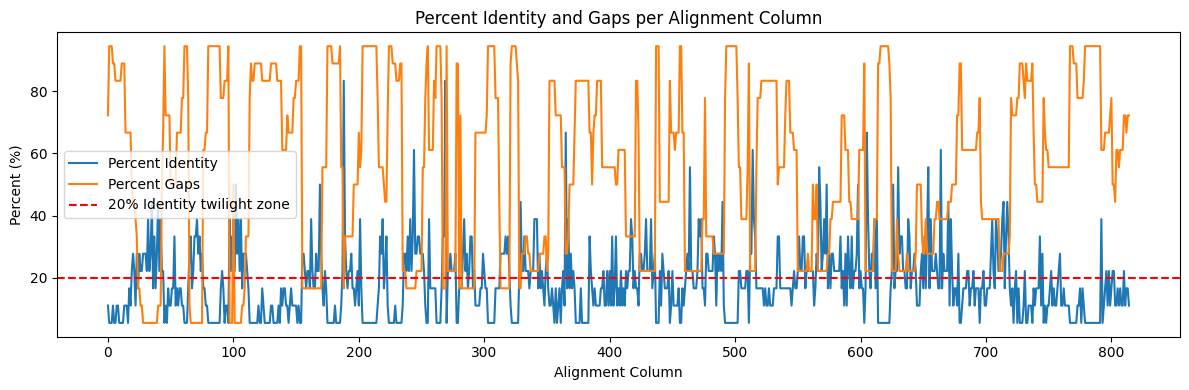

In [125]:
#let's plot the identity and gaps

plot_identity_and_gaps(aligned_fasta_path, format='fasta')


In [126]:
import numpy as np
import pandas as pd
from Bio import AlignIO

def hamming_distance(seq1, seq2):
	"""Compute Hamming distance between two aligned sequences (counting only non-gap positions)."""
	assert len(seq1) == len(seq2)
	return sum((a != b) and (a != '-' and b != '-') for a, b in zip(seq1, seq2)) /  ( max (  len(seq1.replace('-', '')) , len(seq2.replace('-', ''))  ) + 10**-6 )

def hamming_distance_matrix(alignment_path, format='fasta'):
	"""
	Compute the Hamming distance matrix for all sequences in an alignment file.
	Returns a pandas DataFrame with sequence IDs as row/column labels.
	"""
	alignment = AlignIO.read(alignment_path, format)
	ids = [record.id for record in alignment]
	n = len(alignment)
	matrix = np.zeros((n, n), dtype=float)
	for i in range(n):
		for j in range(n):
			if i <= j:
				dist = hamming_distance(str(alignment[i].seq), str(alignment[j].seq))
				matrix[i, j] = dist
				matrix[j, i] = dist
	df = pd.DataFrame(matrix, index=ids, columns=ids)
	return df

#we can calculate the hamming distance matrix between the sequences
hamming_df = hamming_distance_matrix(aligned_fasta_path, format='fasta')


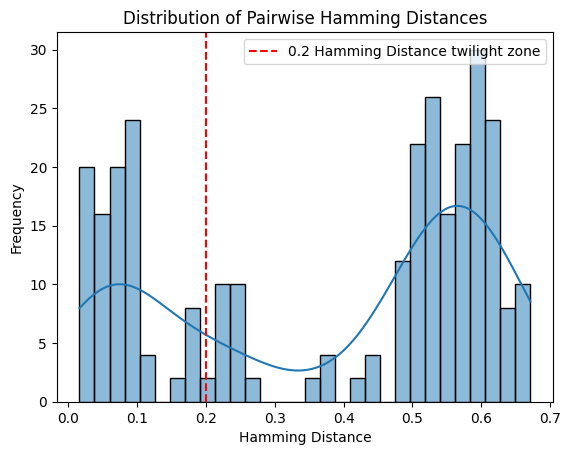

(18, 18) hamming distance matrix shape


In [127]:
#plot the distribution of the distances
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distance_distribution(df):
	"""
	Plot the distribution of pairwise distances from a distance matrix DataFrame.
	"""
	distances = df.values.flatten()
	distances = distances[distances > 0]  # Remove zero distances
	sns.histplot(distances, bins=30, kde=True)
	#draw a vertical line at 0.2
	plt.axvline(x=0.2, color='r', linestyle='--', label='0.2 Hamming Distance twilight zone')
	plt.xlabel('Hamming Distance')
	plt.ylabel('Frequency')
	plt.legend()
	plt.title('Distribution of Pairwise Hamming Distances')
	plt.show()
#plot the distribution of the distances
plot_distance_distribution(hamming_df)
print(hamming_df.shape, 'hamming distance matrix shape')



In [128]:
#to give ourselves a better idea of what this means lets make some random sequences and align them

import random
AAs = 'ACDEFGHIKLMNPQRSTVWY'
def generate_random_sequence(length):
	"""Generate a random sequence of amino acids."""
	return ''.join(random.choice(AAs) for _ in range(length))
#lets make a gaussian distribution around 100 residues of length
lenghts = np.random.normal( 500, 10,len(fusexins) ).astype(int)

FASTA file written to random_sequences.fasta
Aligned FASTA file written to random_sequences_aligned.fasta
(18, 18)


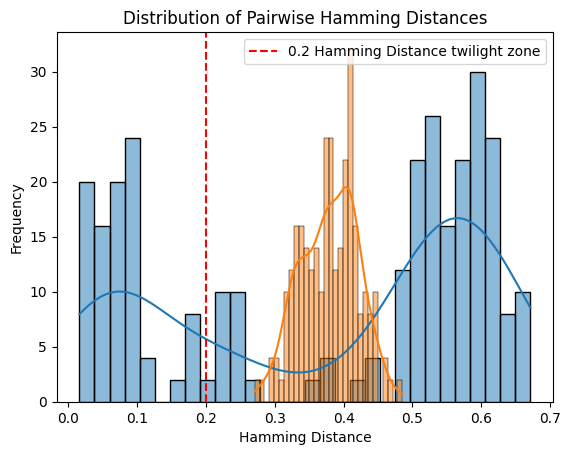

In [129]:

#lets make a random sequence for each length
random_sequences = [generate_random_sequence(length) for length in lenghts]
#lets make a fasta file with the sequences
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import SeqIO

seq_records = []
for i, seq in enumerate(random_sequences):
	record = SeqRecord(Seq(seq), id=f'random_{i}')
	seq_records.append(record)
# Write to FASTA file
fasta_path = "random_sequences.fasta"
SeqIO.write(seq_records, fasta_path, "fasta" )
print(f"FASTA file written to {fasta_path}")
#align the random sequences
mafft_result = run_mafft_on_fasta(fasta_path)
# Save the aligned sequences to a file
rand_aligned_fasta_path = "random_sequences_aligned.fasta"
with open(rand_aligned_fasta_path, 'w') as f:
	f.write(mafft_result)
print(f"Aligned FASTA file written to {rand_aligned_fasta_path}")
#find the hamming distance matrix
rand_hamming_df = hamming_distance_matrix(rand_aligned_fasta_path, format='fasta')

print( rand_hamming_df.shape )

#add it to the plot
def plot_distance_distribution(dfs):
	"""
	Plot the distribution of pairwise distances from a distance matrix DataFrame.
	"""
	for df in dfs:
		distances = df.values.flatten()
		distances = distances[distances > 0]
		distances = df.values.flatten()
		distances = distances[distances > 0]  # Remove zero distances
		sns.histplot(distances, kde=True , bins=30)
	#draw a vertical line at 0.2
	plt.axvline(x=0.2, color='r', linestyle='--', label='0.2 Hamming Distance twilight zone')
	plt.xlabel('Hamming Distance')
	plt.ylabel('Frequency')
	plt.legend()
	plt.title('Distribution of Pairwise Hamming Distances')
	plt.show()
#plot the distribution of the distances
plot_distance_distribution([ hamming_df , rand_hamming_df ])

### Exploring Sequence Conservation and Alignment Approaches

Now that you have generated a multiple sequence alignment (MSA), you can inspect it visually using tools like **Jalview** or **AliView**. These tools allow you to:

- Identify **conserved positions** across all fusexin homologs.
- Highlight regions with high sequence variability or gaps.
- Examine whether conserved residues correspond to known functional motifs or structural features (e.g., the fusion loop).

#### Questions for Exploration

- **Are there any highly conserved positions in the alignment?**  
	Do these conserved residues cluster in specific domains or functional regions of the protein?

- **How do the conserved sequence positions compare to structurally conserved regions?**  
	Are the residues that are structurally aligned by rigid body superposition also conserved at the sequence level?

- **What challenges arise when aligning highly divergent homologs?**  
	When sequence identity is low, do sequence-based alignments still correctly align functionally equivalent residues, or do they become ambiguous?

- **What could cause two sequences to diverge to levels below those of random chance?**  
	Consider the evolutionary pressures that might lead to such divergence. Are there specific functional constraints or structural requirements that could drive this process?

- **How does structural alignment (e.g., rigid body superposition) differ from sequence alignment in this context?**  
	Can structural methods align homologous residues that are no longer detectable by sequence similarity alone? What are the limitations of each approach?

#### Reflection

When homologs are highly divergent, **sequence-based alignments** may fail to correctly align functionally equivalent or structurally important residues, especially in regions with low conservation. In contrast, **structure-based alignments** can often reveal deeper evolutionary relationships by aligning residues based on their 3D positions, even when sequence similarity is minimal. Let's press on and make the tree!

In [119]:
#run the IQ-TREE analysis
#this will take a while since we are running 25 bootstraps
files, iqtree_result = run_iqtree_with_lg_invariant(aligned_fasta_path)
# Save the IQ-TREE output to a file
iqtree_output_path = "iqtree_output.txt"
with open(iqtree_output_path, 'w') as f:
	f.write(iqtree_result.stdout)

['fusexins_aligned.fasta.treefile', 'fusexins_aligned.fasta.log', 'fusexins_aligned.fasta.iqtree'] output files


In [120]:
import toytree
MLtreefile = 'fusexins_aligned.fasta.treefile'
#display the tree
with open(MLtreefile) as f:
	tree = f.read()
	tree = toytree.tree(tree)
#display the tree

tree.draw( width=800, height=600,  node_labels='support' , scale=True , node_labels_style={'font-size': 15 , 'font-weight':'bold' , 'fill':'red' } )

unrecognized arguments skipped: ['scale']
check the docs, argument names may have changed.


(<toyplot.canvas.Canvas at 0x7ff32f870f50>,
 <toytree.Render.ToytreeMark at 0x7ff32f8633b0>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="800.0px" height="600.0px" viewBox="0 0 800.0 600.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t3ae8f57f74a74905ab7302a028d095bf"> 100 92 100 92 100 44 100 28 100 100 60 100 100 52 100 AF-A3FEQ2_hydra 5OW3_A_thaliana AF-Q75JL6_dictyostelium 5mf1_C_reinhardtii 4OJC_C_elegans 4GSX_Dengue 1OAN_Dengue 2I69_west_nile_virus 1SVB_Tick_encephalitis 6EGU_Rift_valley_fever_virus 4HJ1_Rift_vally_fever_virus 2ALA_semliki_forest 1RER_Semliki_Forest_virus 3n43_Chikungunya_virus 7P4L_metageno_halo WP_007110832_Naltunense WP_058826362_Haloferax WP_049937247_Hnatans

### Interpreting the Eukaryotic Portion of the Fusexin Phylogeny

The eukaryotic sequences in the phylogenetic tree generally cluster in a manner that is **congruent with the known species tree**—for example, plant, animal, and protist fusexins group according to their evolutionary relationships. This congruence suggests that, at least for the eukaryotic clade, the tree topology reflects true evolutionary history rather than artifacts of alignment or model choice.

#### Observations on Topology

- **Eukaryotic clades** are well-separated from archaeal and viral homologs, mirroring expected deep evolutionary splits.
- Within the eukaryotes, **closely related species** (e.g., choanoflagelates and metazoans) tend to cluster together, is the ordering ok on this topology?

#### Bootstrap Support

- **High bootstrap values** indicate strong statistical support for these groupings, suggesting that the data robustly support these evolutionary relationships.
- **Lower bootstrap values** in some regions (especially among highly divergent or poorly aligned sequences) highlight areas of uncertainty, where the alignment or evolutionary model may not provide a clear signal.

#### Alignment Quality and Tree Reliability

Given the **high sequence divergence** and the presence of many gaps in the alignment, caution is warranted when interpreting deeper or poorly supported nodes. While the eukaryotic portion of the tree is likely reliable—supported by both congruence with the species tree and strong bootstrap values—other regions of the tree (especially those with low support or involving highly divergent sequences) should be interpreted more skeptically. The overall **quality of the alignment** is a critical factor: well-aligned, conserved regions yield more trustworthy phylogenetic inferences, while ambiguous or saturated regions can mislead tree reconstruction.

In [121]:


# now let's use foldtree and some basic structural phylogenetics
from fold_tree.src.foldseek2tree import *

### Foldseek 3Di Alphabet and Local Structural Embedding

Foldseek introduces the **3Di structural alphabet**, which encodes local protein backbone geometry into discrete "letters" using a sliding window approach. Each window of six amino acids is mapped to a 3Di character based on its local 3D conformation. This process transforms the complex 3D structure of a protein into a sequence of structural alphabet letters, enabling rapid and sensitive structure comparison using sequence alignment techniques.

The key advantage of this local embedding is that it captures **local structural features** independent of the global fold or large conformational changes. As a result, Foldseek can robustly compare proteins even when they exhibit significant domain movements or flexibility, focusing on conserved local motifs that are often critical for function and evolution.

![Foldseek 3Di Alphabet Illustration](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41587-023-01773-0/MediaObjects/41587_2023_1773_Fig1_HTML.png?as=webp)

### Foldseek Structural Alphabet: Local Structural Characters for Evolutionary Analysis

This local encoding enables **rapid structural comparison** by transforming the 3D alignment problem into a much faster string alignment task. Importantly, the local nature of the structural alphabet makes Foldseek-based comparisons robust to conformational variability, allowing for more accurate estimation of **evolutionary distances** between homologous proteins, even when their overall shapes differ due to flexibility or experimental conditions.

Our study ([Moi et al., 2023](https://www.biorxiv.org/content/10.1101/2023.09.19.558401v2)) demonstrated that using Foldseek-derived structural distances provides improved accuracy for reconstructing evolutionary relationships, especially for highly divergent protein families.


In [122]:
#let's use foldtree to find pairwise structural alignments and compare them to what we got with sequence
comparison , trees = structblob2tree(input_folder = 'fsx1', outfolder = 'fsx1_foldtree' , foldseekpath = 'foldseek' )
print( outfiles , 'outfiles' )
print( trees , 'trees' )

found foldseek output, skipping foldseek
                  query                          target  fident  alnlen  \
0        4OJC_C_elegans                  4OJC_C_elegans   1.000     506   
1        4OJC_C_elegans  6EGU_Rift_valley_fever_virus_B   0.088     531   
2        4OJC_C_elegans       1RER_Semliki_Forest_virus   0.096     476   
3        4OJC_C_elegans     4HJ1_Rift_vally_fever_virus   0.110     505   
4        4OJC_C_elegans         AF-Q75JL6_dictyostelium   0.096     568   
..                  ...                             ...     ...     ...   
356  5mf1_C_reinhardtii            2I69_west_nile_virus   0.102     490   
357  5mf1_C_reinhardtii     4HJ1_Rift_vally_fever_virus   0.117     504   
358  5mf1_C_reinhardtii                   1OAN_Dengue_A   0.076     485   
359  5mf1_C_reinhardtii                   1OAN_Dengue_B   0.073     489   
360  5mf1_C_reinhardtii          1SVB_Tick_encephalitis   0.089     504   

     mismatch  gapopen  qstart  qend  tstart  tend        

            query                          target  fident  alnlen  mismatch  \
0  4OJC_C_elegans                  4OJC_C_elegans   1.000     506         0   
1  4OJC_C_elegans  6EGU_Rift_valley_fever_virus_B   0.088     531       346   
2  4OJC_C_elegans       1RER_Semliki_Forest_virus   0.096     476       320   
3  4OJC_C_elegans     4HJ1_Rift_vally_fever_virus   0.110     505       324   
4  4OJC_C_elegans         AF-Q75JL6_dictyostelium   0.096     568       365   

   gapopen  qstart  qend  tstart  tend        evalue  bits    lddt  \
0        0       1   506       1   506  6.673000e-99  4847  1.0000   
1       37      15   498       1   440  1.298000e-14   354  0.4134   
2       30      42   493       2   391  1.915000e-13   329  0.4045   
3       36      24   491      15   431  1.127000e-14   310  0.4159   
4       34       2   490       1   499  3.499000e-14   293  0.3609   

                                            lddtfull  alntmscore  
0  1.000,1.000,1.000,1.000,1.000,1.00

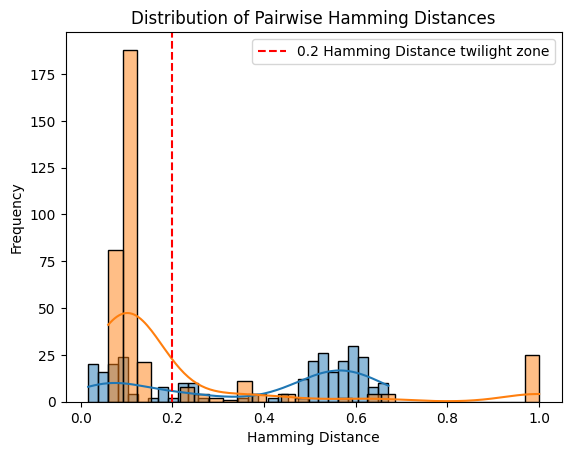

In [123]:
#lets open the all vs all comparison and examine the distances

import pandas as pd
import seaborn as sns
foldseek_distances = pd.read_table( comparison , header = None )
foldseek_distances.columns = 'query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,lddt,lddtfull,alntmscore'.split(',')

#how do the pairwise hamming distances compare to the foldseek hamming distances?
print( foldseek_distances.head() )
plot_distance_distribution([ hamming_df  , foldseek_distances[['fident']].copy() ] )

## Why Does Structural Geometry Remain Constrained While Sequence Divergence Saturates?

So after considering which residues are actually geometrically equivalent, we are actually much lower than random divergence! Here are some key questions to consider, each with some food for thought:

- **Why does protein structure remain conserved even as sequence divergence saturates?**  
	*Food for thought:* The three-dimensional fold of a protein is often maintained by a network of interactions that can be preserved through many different amino acid combinations. This suggests that the requirements for a stable, functional fold are much more restrictive than the vast possibilities of sequence space.

- **What does the persistence of structural similarity, despite extreme sequence divergence, tell us about the relationship between sequence space and the limited number of protein folds in nature?**  
	*Food for thought:* While there are astronomically many possible sequences, only a small subset can produce a stable, functional structure. This "many-to-one" mapping means that evolution can explore sequence space freely, but functional constraints funnel many sequences into the same structural solutions.

- **How does the ability of different sequences to map onto the same fold impact protein engineering and drug design?**  
	*Food for thought:* This property enables the design of novel proteins with desired functions by targeting structural features rather than specific sequences. It also means that drugs targeting a particular fold may be effective across diverse sequences, but also that resistance can evolve through sequence changes that preserve the fold.

- **What are the implications for our understanding of protein evolution?**  
	*Food for thought:* The conservation of structure over sequence highlights the importance of structural constraints in evolutionary processes. It also suggests that distant homologs may be missed by sequence-based methods, but detected by structural comparison.

- **What does this mean for alignment methods that rely solely on average substitution models and ignore structure?**  
	*Food for thought:* Sequence-based alignments may fail to correctly align functionally or structurally equivalent residues when divergence is high. Incorporating structural information can reveal deeper evolutionary relationships and improve the accuracy of alignments, especially for highly divergent proteins.

Reflect on how these points shape our strategies for studying protein evolution, designing new proteins, and interpreting the results of sequence and structure-based analyses.


In [136]:
import toytree

#lets visualize the tree and compare the maximum likelihood tree with toytree
def show_two_trees_with_fixed_order(tree1_newick, tree2_newick):
	"""
	Visualize two trees side by side in toytree, with leaf order defined by the first tree,
	using coalescent ('c') style.

	Args:
		tree1_newick (str): Newick string for the reference tree (defines leaf order).
		tree2_newick (str): Newick string for the second tree to compare.
	"""
	# Load trees
	with open(tree1_newick) as f:
		tree1_newick = f.read().strip()
	with open(tree2_newick) as f:
		tree2_newick = f.read().strip()
	t1 = toytree.tree(tree1_newick)
	t2 = toytree.tree(tree2_newick)
	# Get leaf order from first tree
	leaf_order = t1.get_tip_labels()
	# Draw both trees with the same leaf order, facing each other (left and right), with fixed tip order

	# Draw the first tree (left, normal orientation)
	t1.draw(
		width=400,
		height=600,
		tip_labels_align=True,
		tip_labels=leaf_order,
		node_labels='support',
		node_labels_style={'font-size': 15, 'font-weight': 'bold', 'fill': 'red'},
		scale_bar=True,
		edge_type='c',

		orientation='right'
	)

	leaf_order = [ l for l in leaf_order if l in t2.get_tip_labels() ]
	# Draw the second tree (right, mirrored orientation)
	t2.draw(
		width=400,
		height=600,
		tip_labels_align=True,
		node_labels='support',
		node_labels_style={'font-size': 15, 'font-weight': 'bold', 'fill': 'red'},
		edge_type='c',

		scale_bar=True,
		layout='l'
	)


In [137]:
show_two_trees_with_fixed_order( trees['fident'] , MLtreefile )

unrecognized arguments skipped: ['scale_bar', 'orientation']
check the docs, argument names may have changed.
unrecognized arguments skipped: ['scale_bar']
check the docs, argument names may have changed.


<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="400.0px" height="600.0px" viewBox="0 0 400.0 600.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t696fbcfa766745e78d64beda54c8a9a0"> 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7P4L_metageno_halo WP_058826362_Haloferax WP_007110832_Naltunense WP_049937247_Hnatans AF-A3FEQ2_hydra AF-Q75JL6_dictyostelium 5mf1_C_reinhardtii 5OW3_A_thaliana 4OJC_C_elegans 1OAN_Dengue_B 1OAN_Dengue_A 1SVB_Tick_encephalitis 2I69_west_nile_virus 4GSX_Dengue 2ALA_semliki_forest 3n43_Chikungunya_virus 1RER_Semliki_Forest_virus 4HJ1_Rift_vally_fever_virus 6EGU_Rift_valley_fever_virus_B

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="400.0px" height="600.0px" viewBox="0 0 400.0 600.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tf001d15c08154721a3868a327da2c9a9"> 100 92 100 92 100 44 100 28 100 100 60 100 100 52 100 AF-A3FEQ2_hydra 5OW3_A_thaliana AF-Q75JL6_dictyostelium 5mf1_C_reinhardtii 4OJC_C_elegans 4GSX_Dengue 1OAN_Dengue 2I69_west_nile_virus 1SVB_Tick_encephalitis 6EGU_Rift_valley_fever_virus 4HJ1_Rift_vally_fever_virus 2ALA_semliki_forest 1RER_Semliki_Forest_virus 3n43_Chikungunya_virus 7P4L_metageno_halo WP_007110832_Naltunense WP_058826362_Haloferax WP_049937247_Hnatans

### Reflection: Parsimony and Structural Phylogeny

Consider the two phylogenetic trees you have generated—one based on sequence data (maximum likelihood) and the other on structural features (Foldseek/foldtree). 

- **Which approach do you think is more parsimonious in explaining the evolutionary relationships among these proteins?**
- **How does the structural phylogeny compare to the sequence-based tree, and what might this tell us about the evolutionary trajectory of the fusexin family?**

Reflect on how local structural conservation versus sequence similarity might influence your interpretation of protein evolution in this context.

# that's it for the introduction! Let's move on to another example that's a bit more complex.